In [ ]:
import warnings
import numpy as np
import pandas as pd
import random
import torch
from torch import nn
import gdown
import scanpy as sc
import evaluate
from dataset import set_seed, preprocessing
import gc
import models_MMD as models
import wandb
warnings.filterwarnings('ignore')

set_seed(0)

dataname = 'PBMC'
adata = sc.read("/home/grads/ywang2542/Perturbation/scPRAM/scOTC/data/PBMC.h5ad")
P01574_embedding_mean = np.load("/home/grads/ywang2542/Perturbation/Embedding/scDistillOTC/data/P01574_embedding_mean.npy")
adata_embedding = sc.read("/home/grads/ywang2542/Perturbation/Embedding/scDistillOTC/data/PBMC_scGPT_new.h5ad")
scGPT_embedding = adata_embedding.obsm['X_scGPT']
key_dic = {'condition_key': 'condition',
        'cell_type_key': 'cell_type',
        'ctrl_key': 'control',
        'stim_key': 'stimulated',
        'pred_key': 'predict',
        }
# ['NK', 'Dendritic', 'CD4T', 'B', 'FCGR3A+Mono', 'CD14+Mono', 'CD8T']

# adata = sc.AnnData(adata.X, obs=adata.obs.copy(), var=adata.var.copy())
adata.obs_names_make_unique()
print(adata)

adata = preprocessing(adata, fe=P01574_embedding_mean, LLMe=scGPT_embedding)


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


torch.Size([16893, 6998])

CD4T
perturbation_embedding: True, LLM_embedding: True


  0%|          | 0/400 [00:00<?, ?it/s]

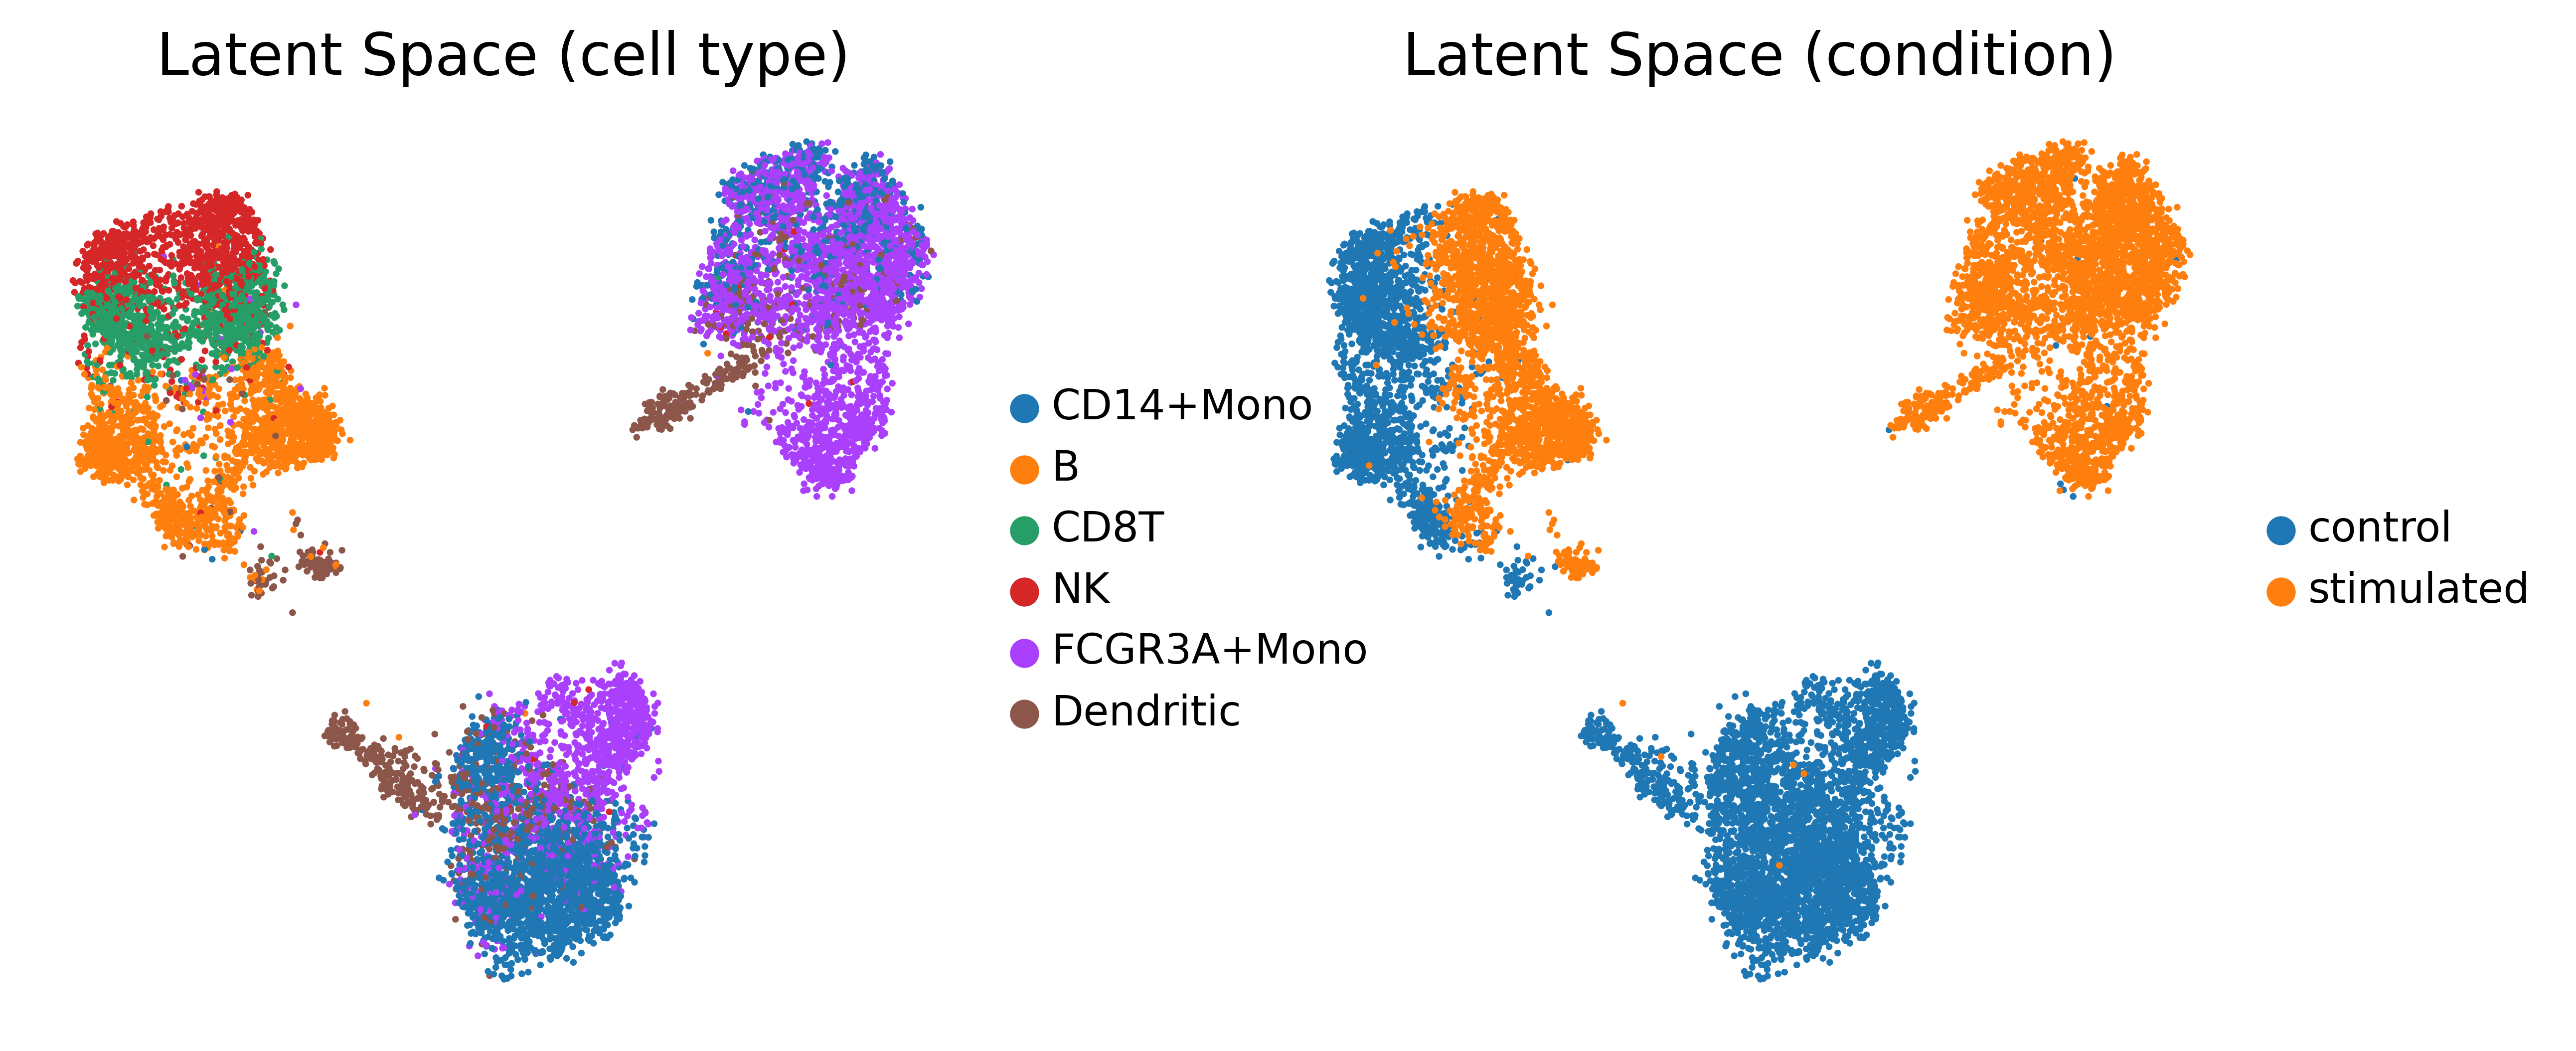

CD4T


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


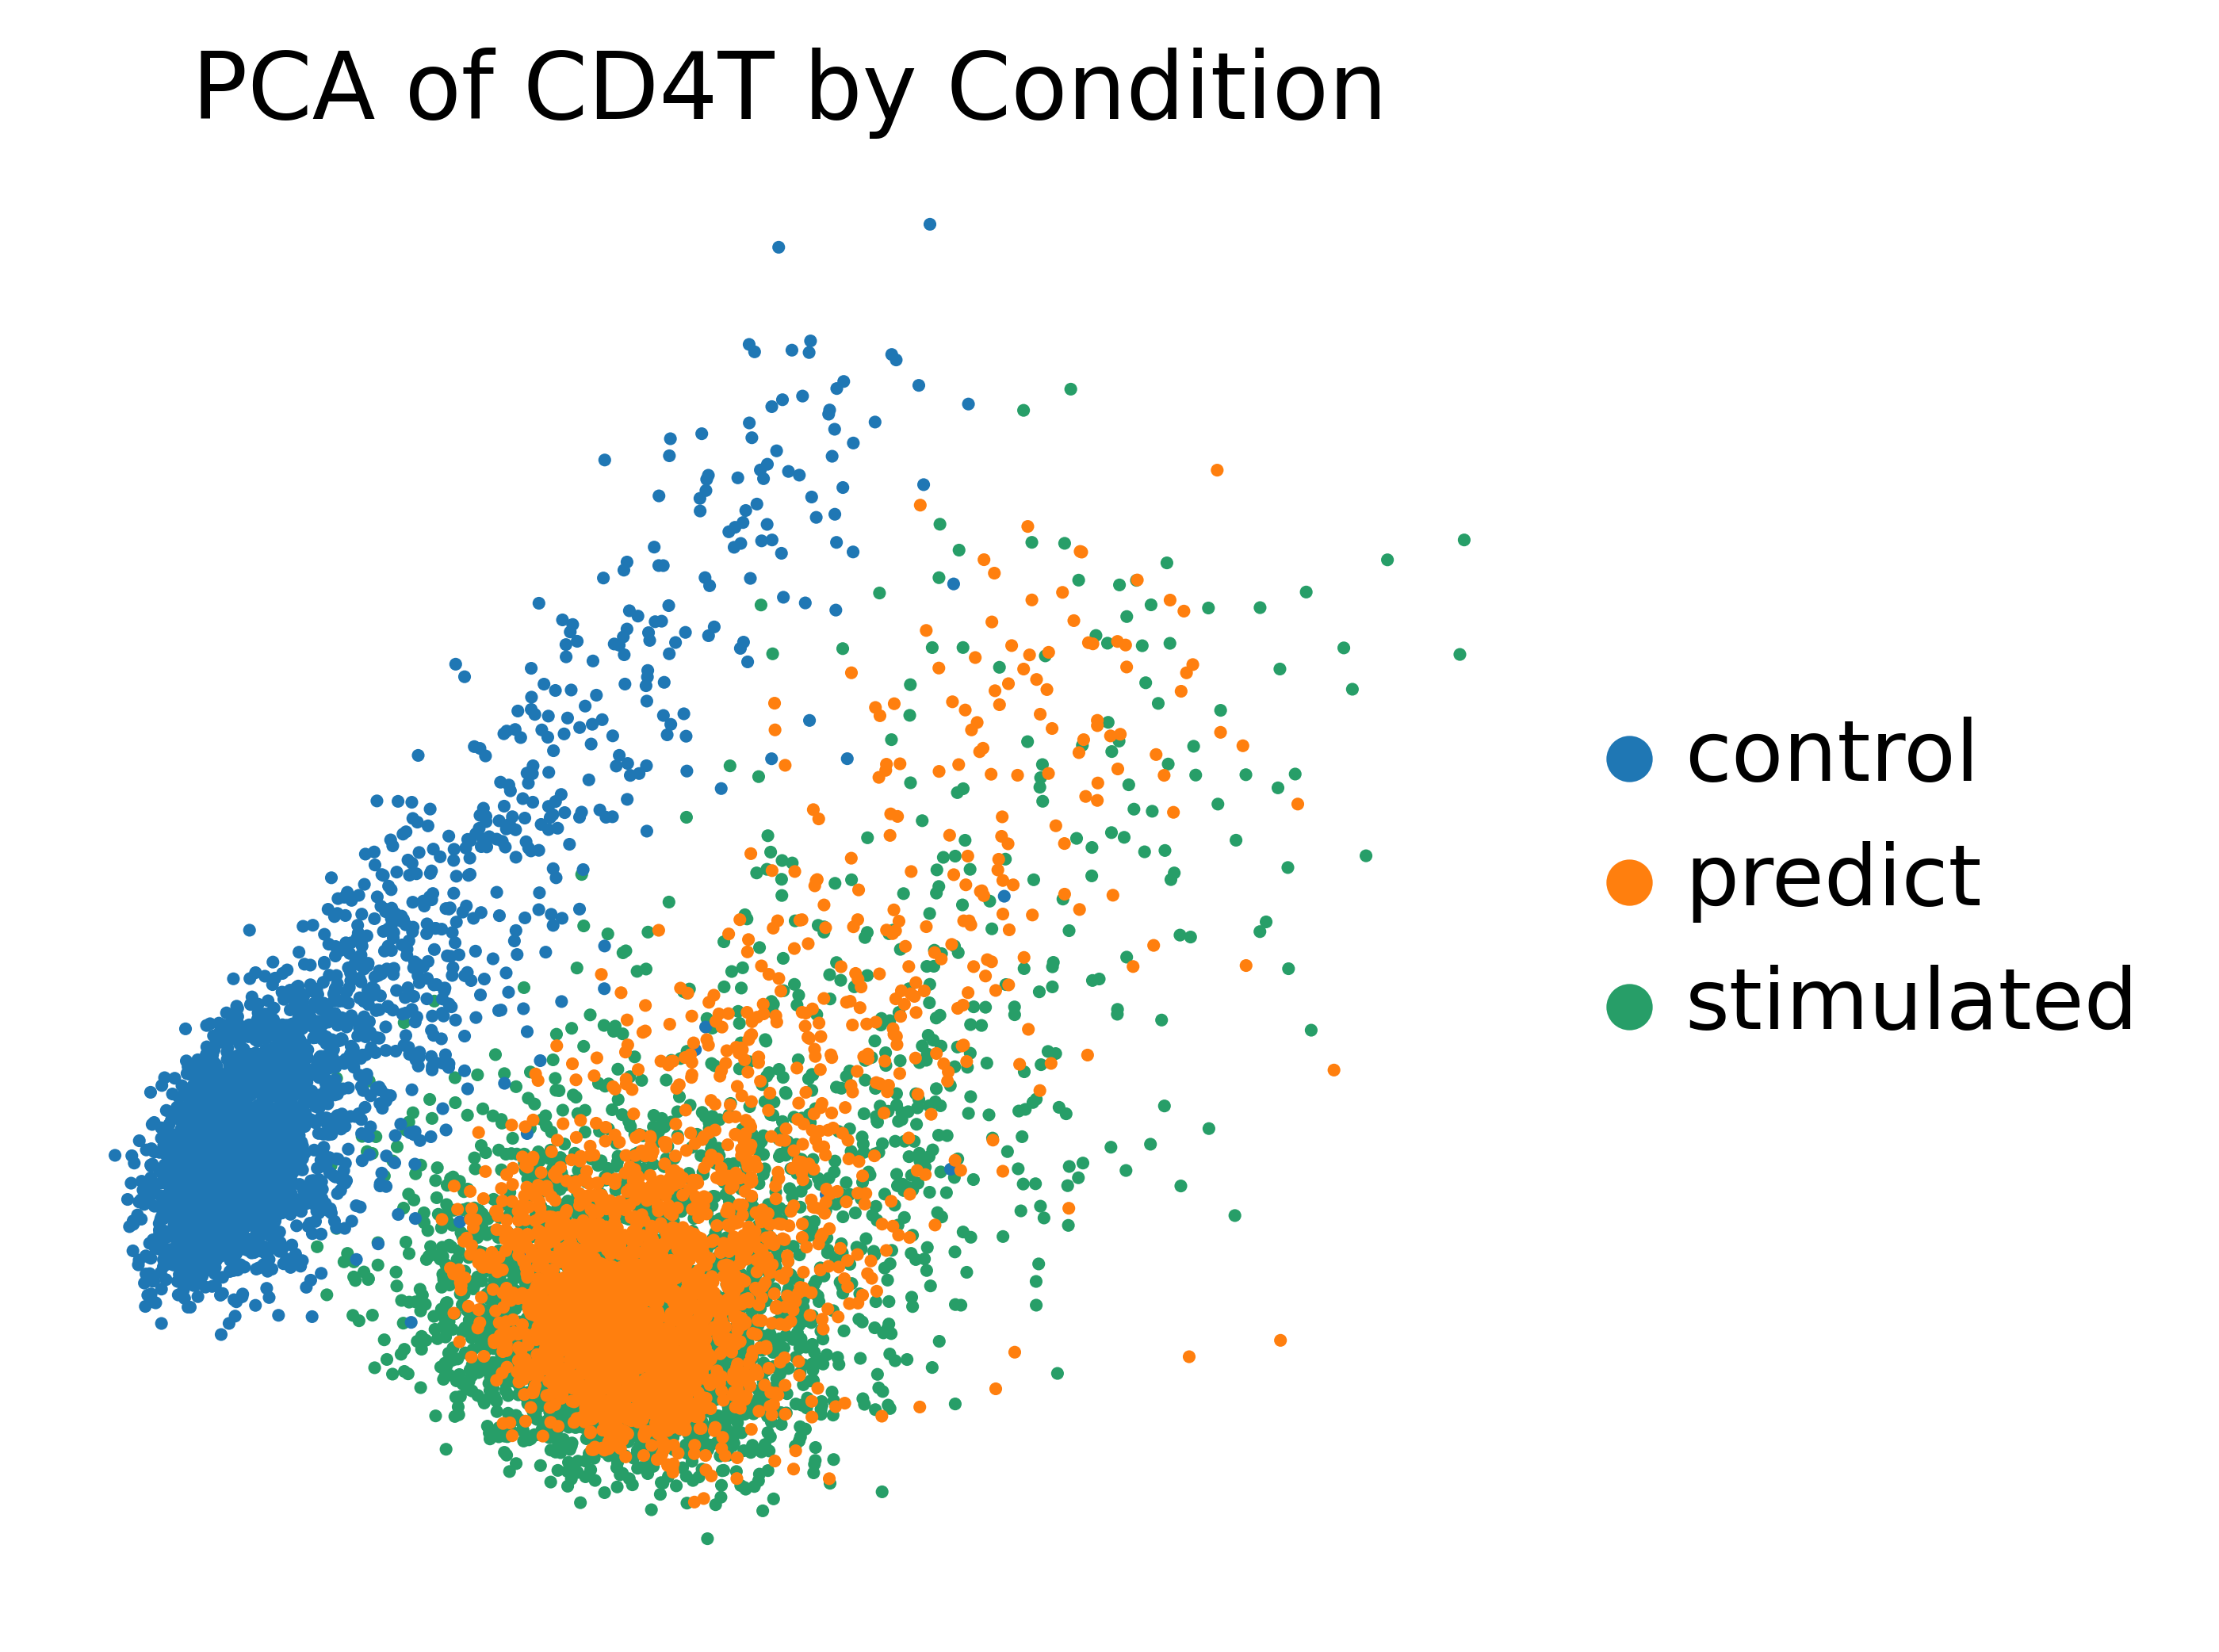

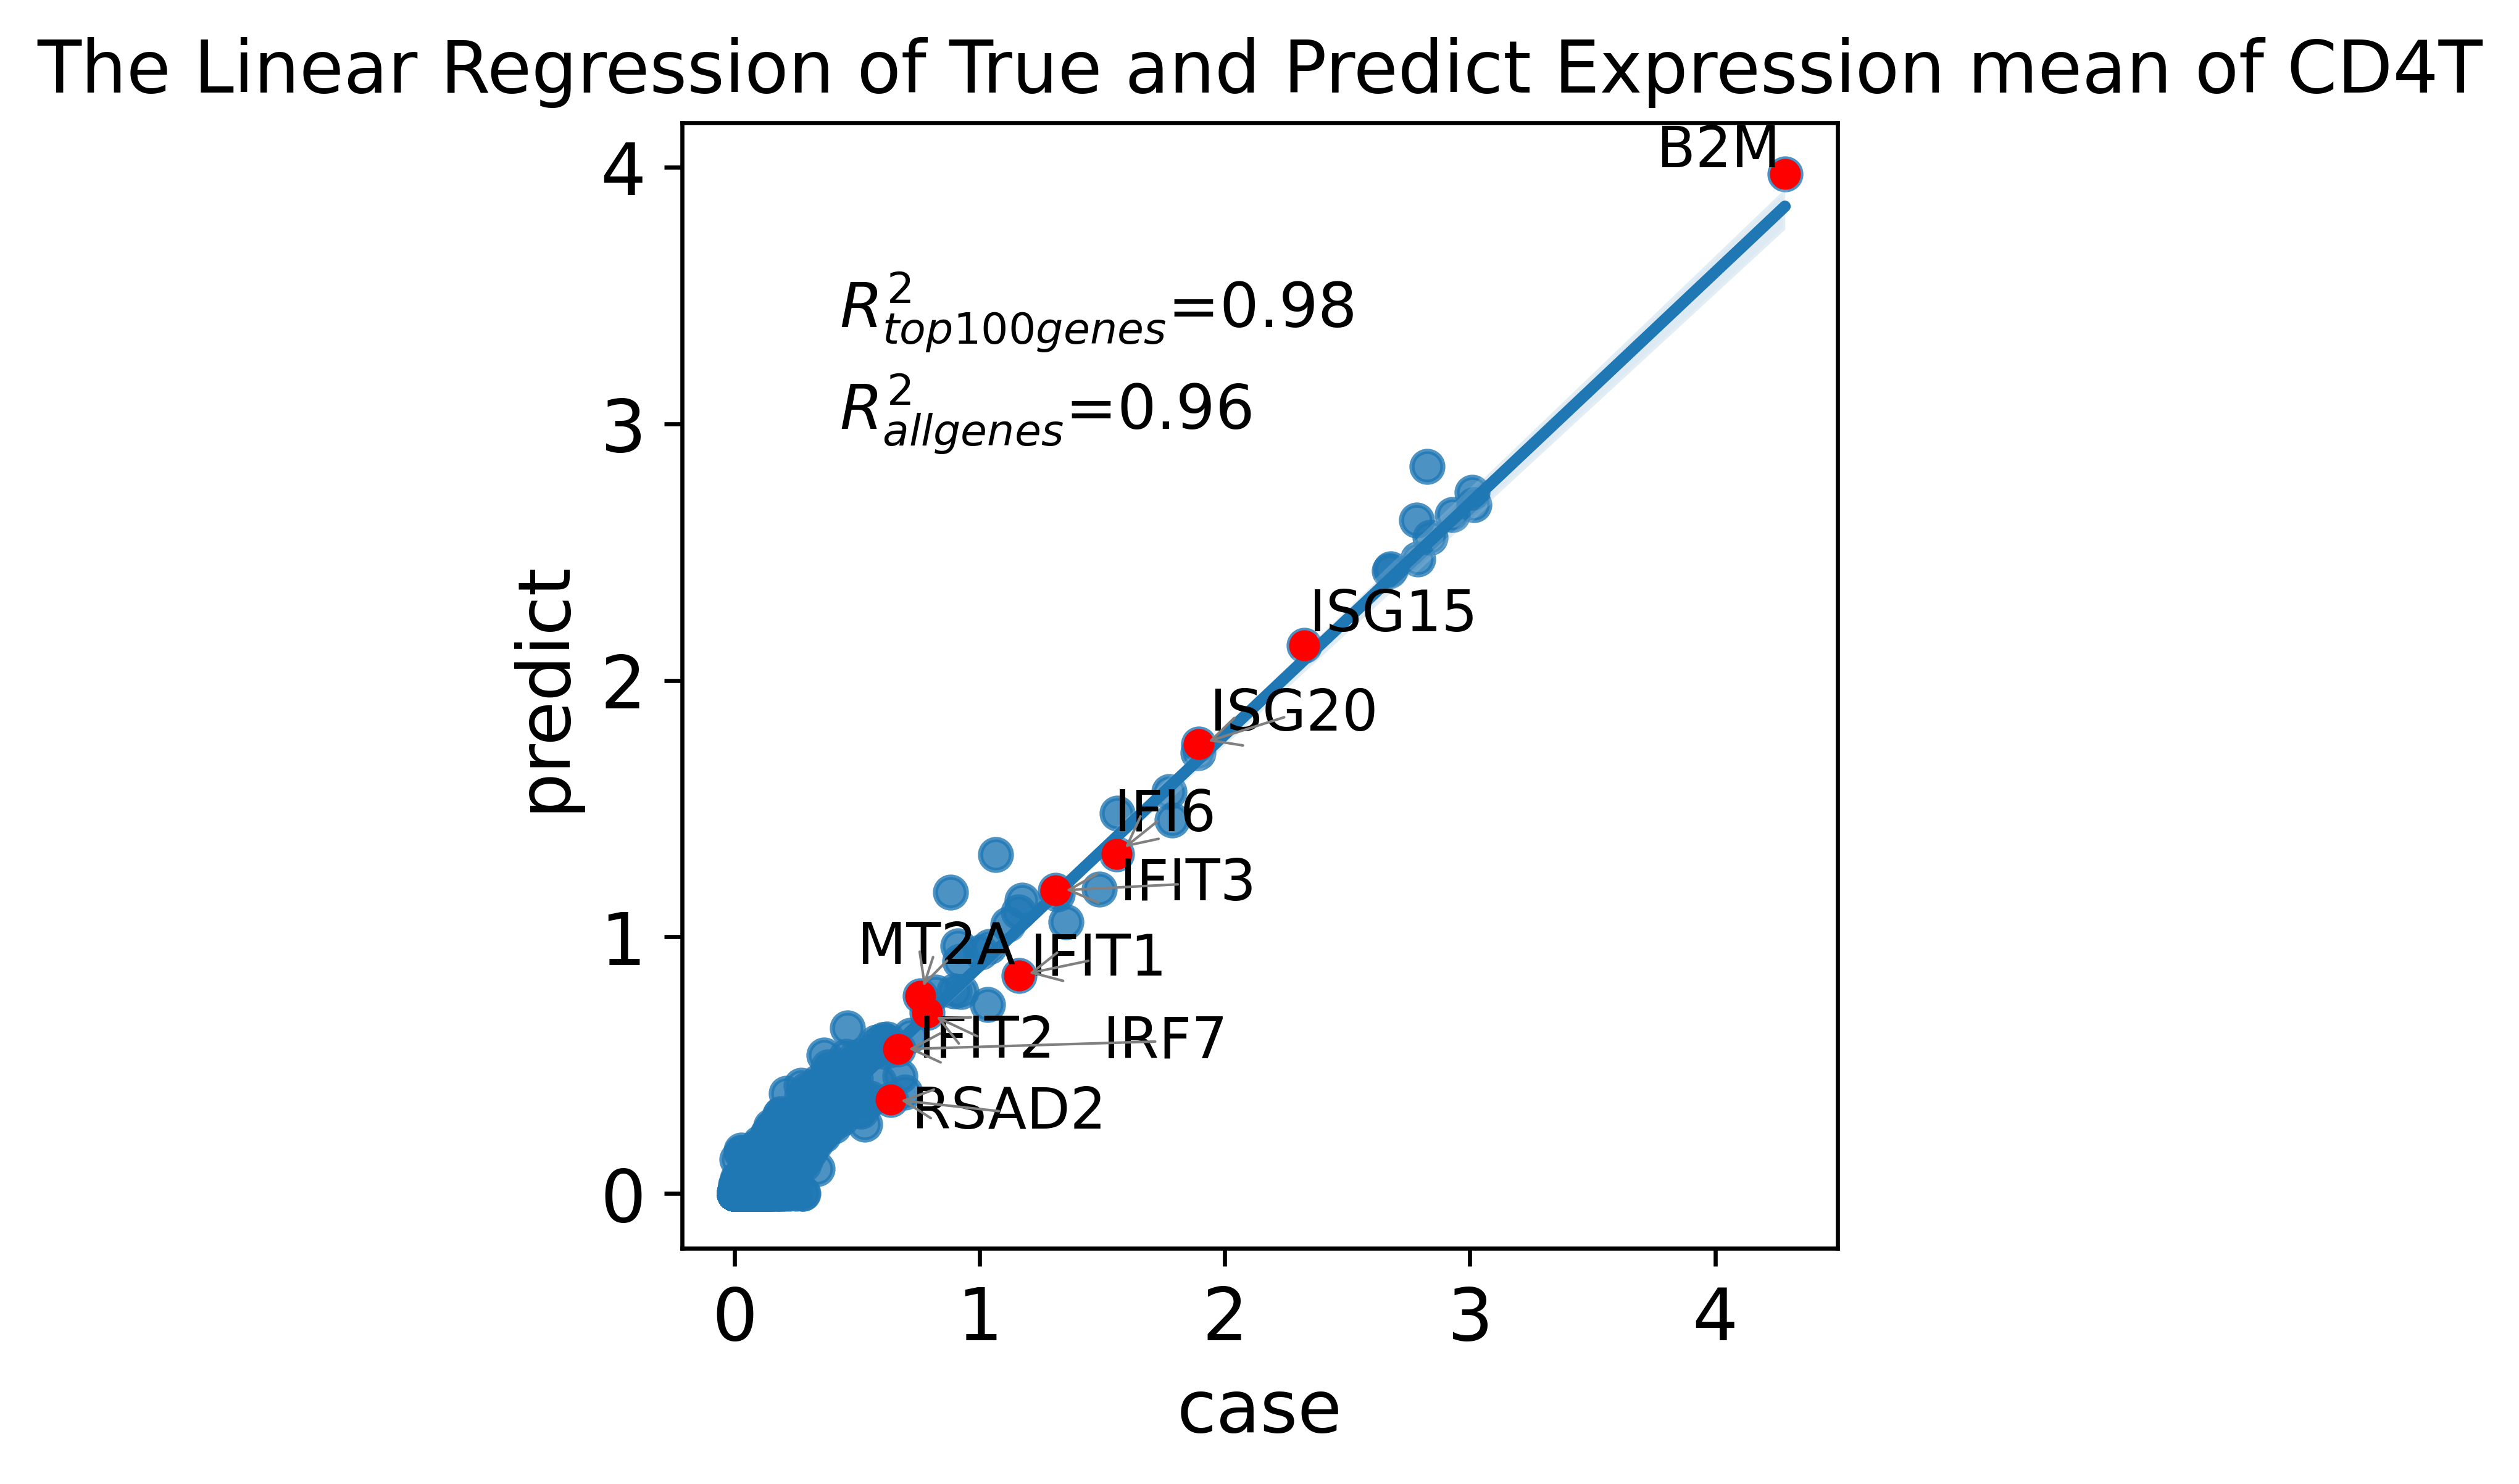

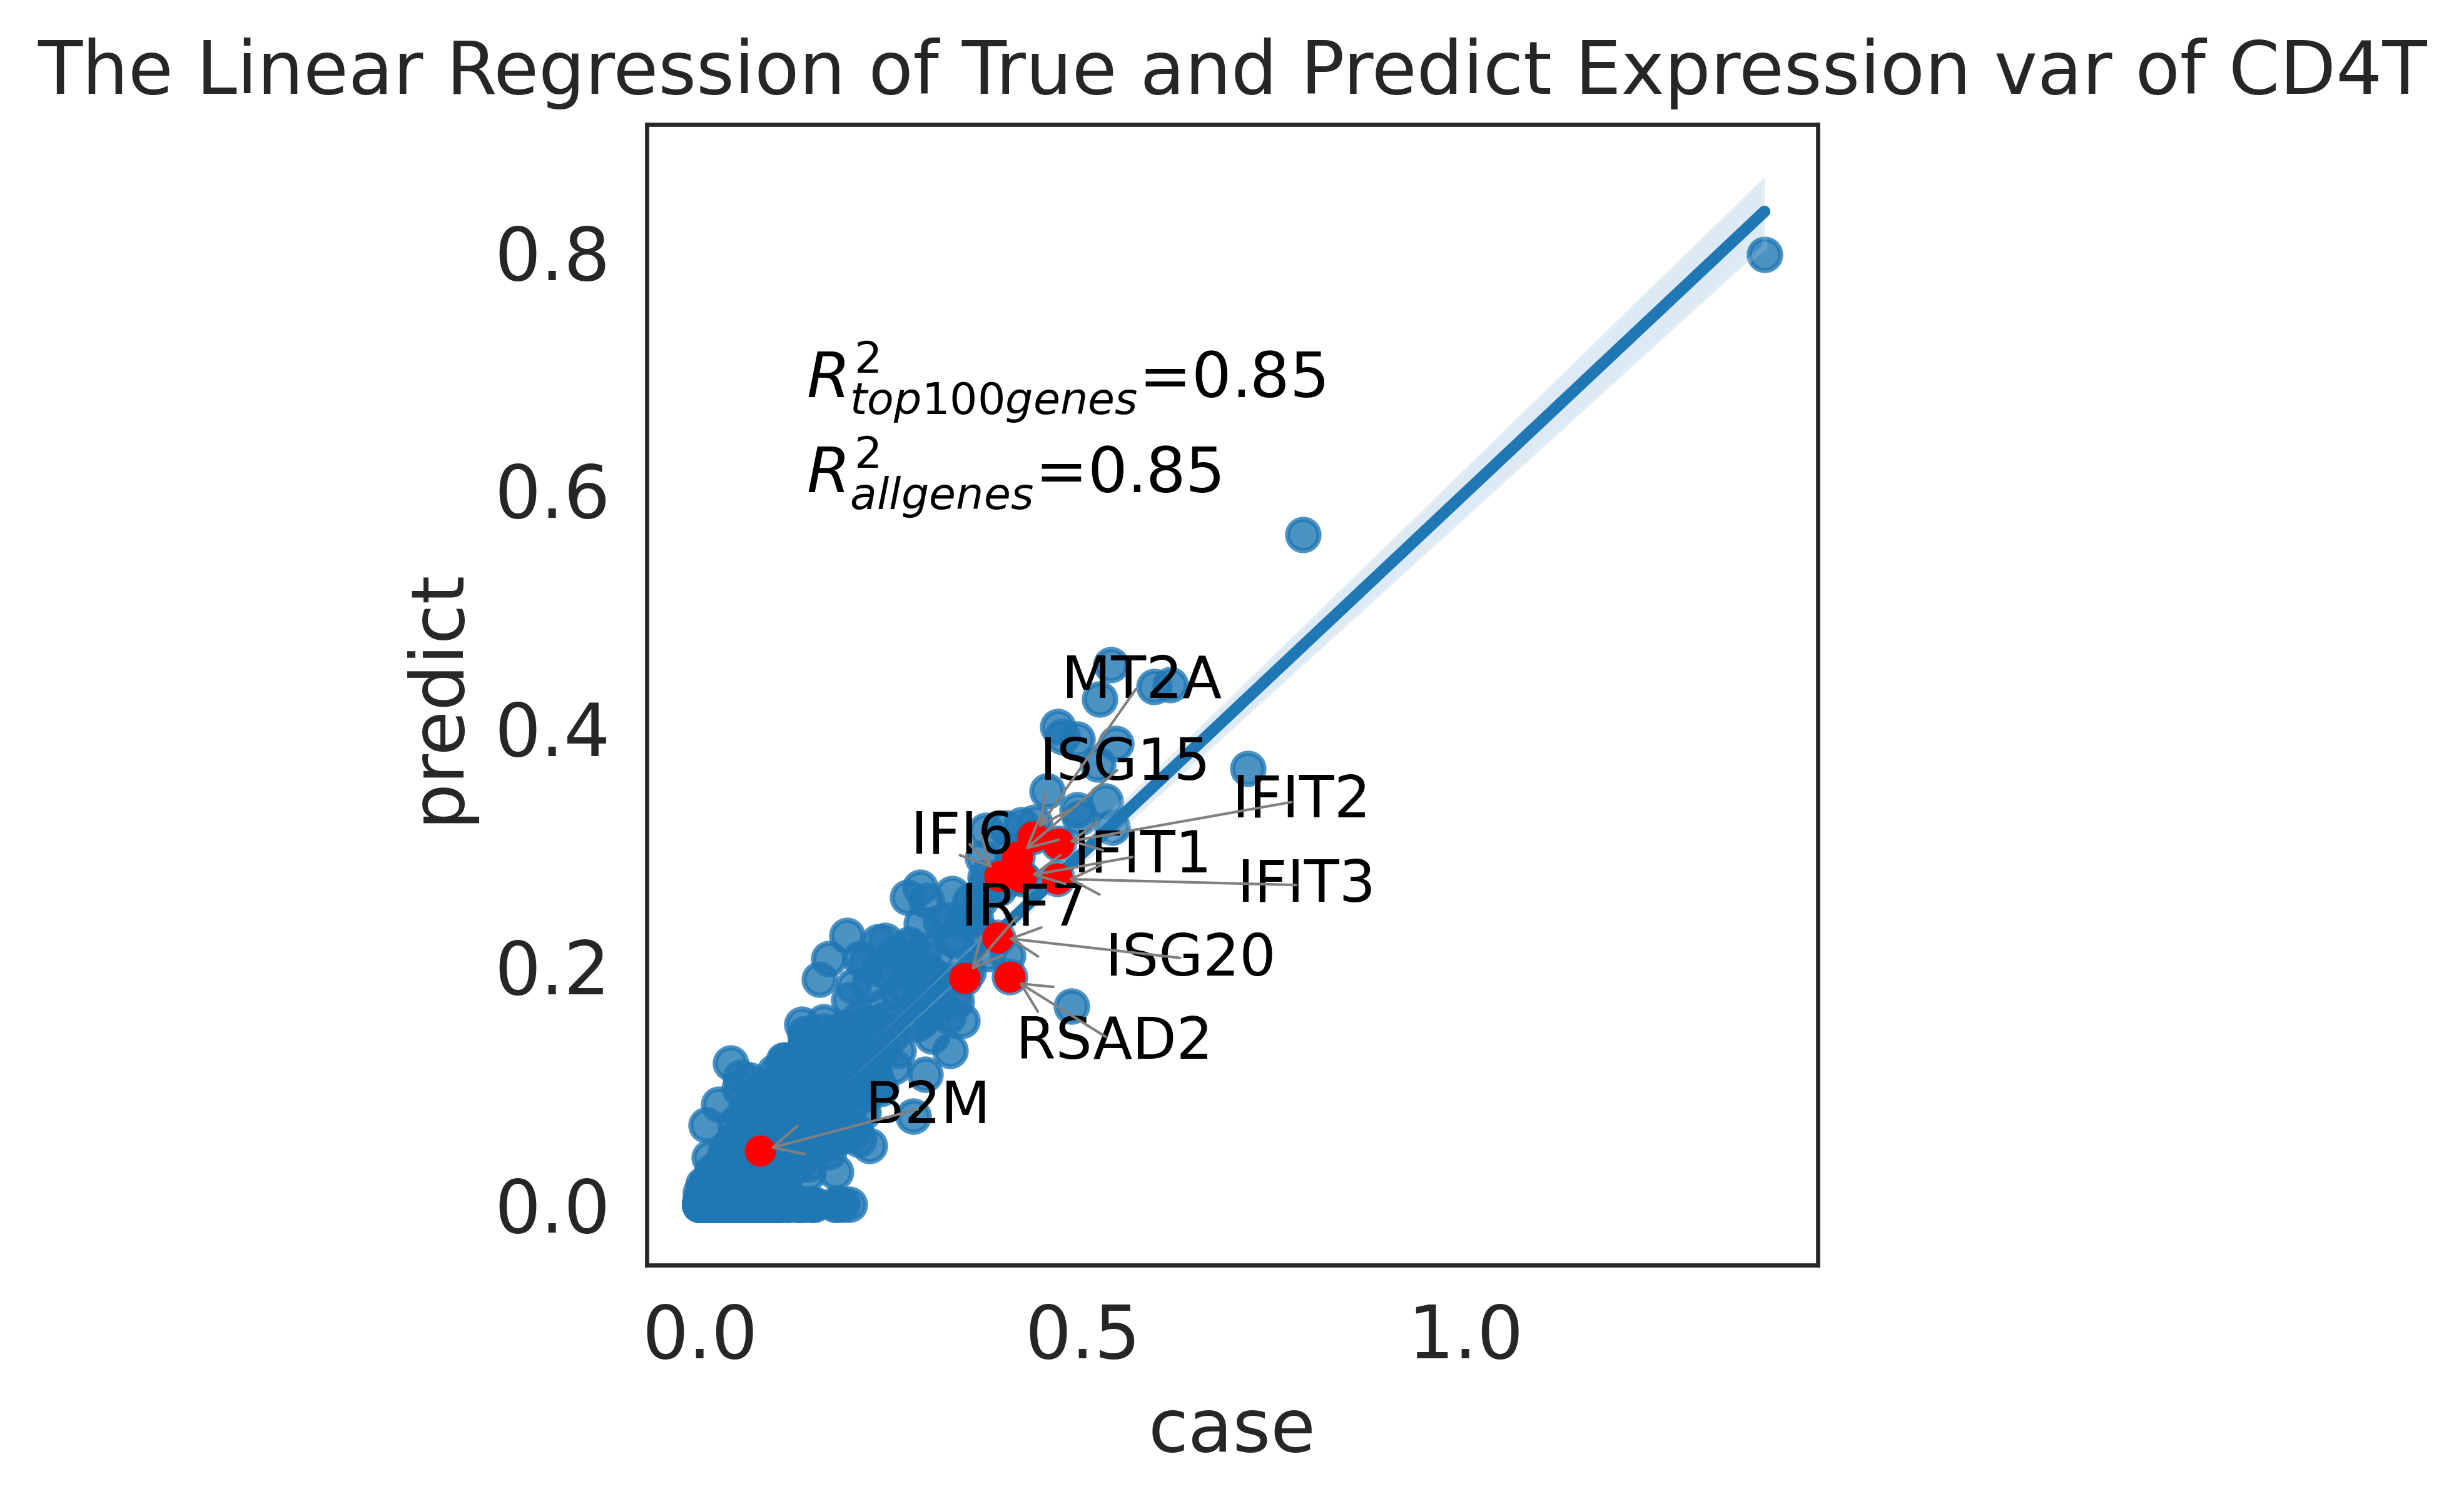

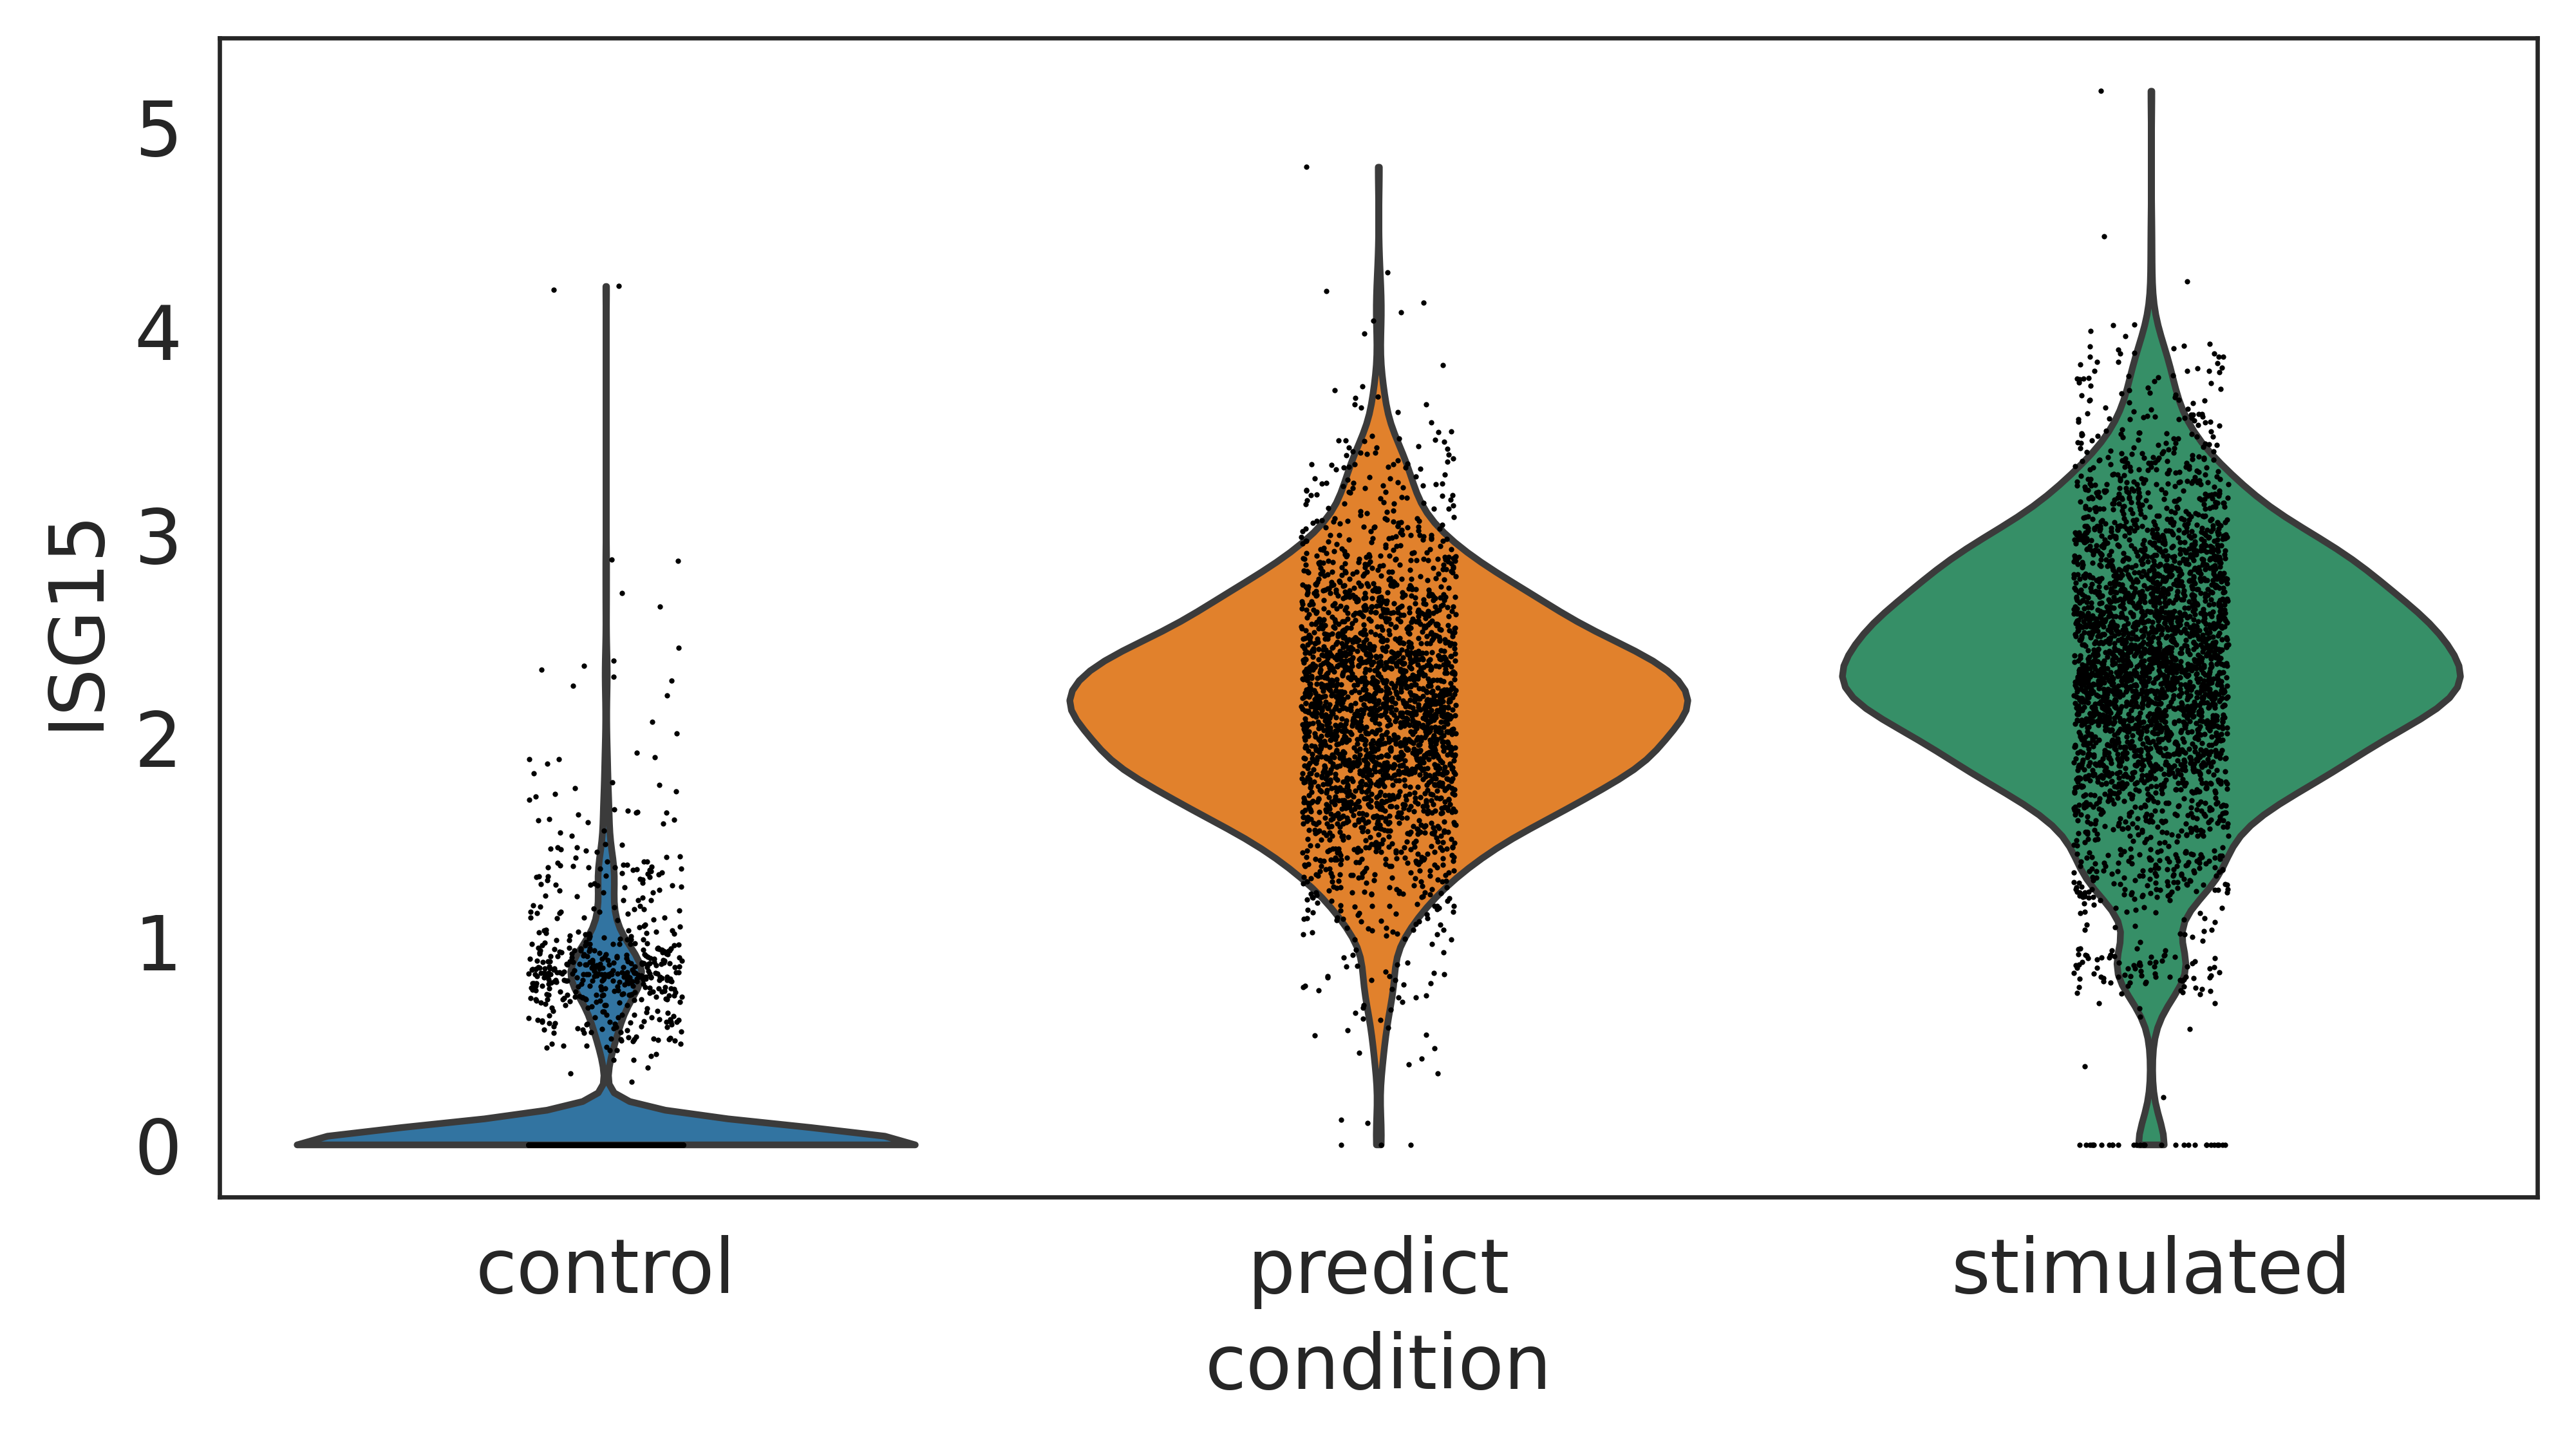

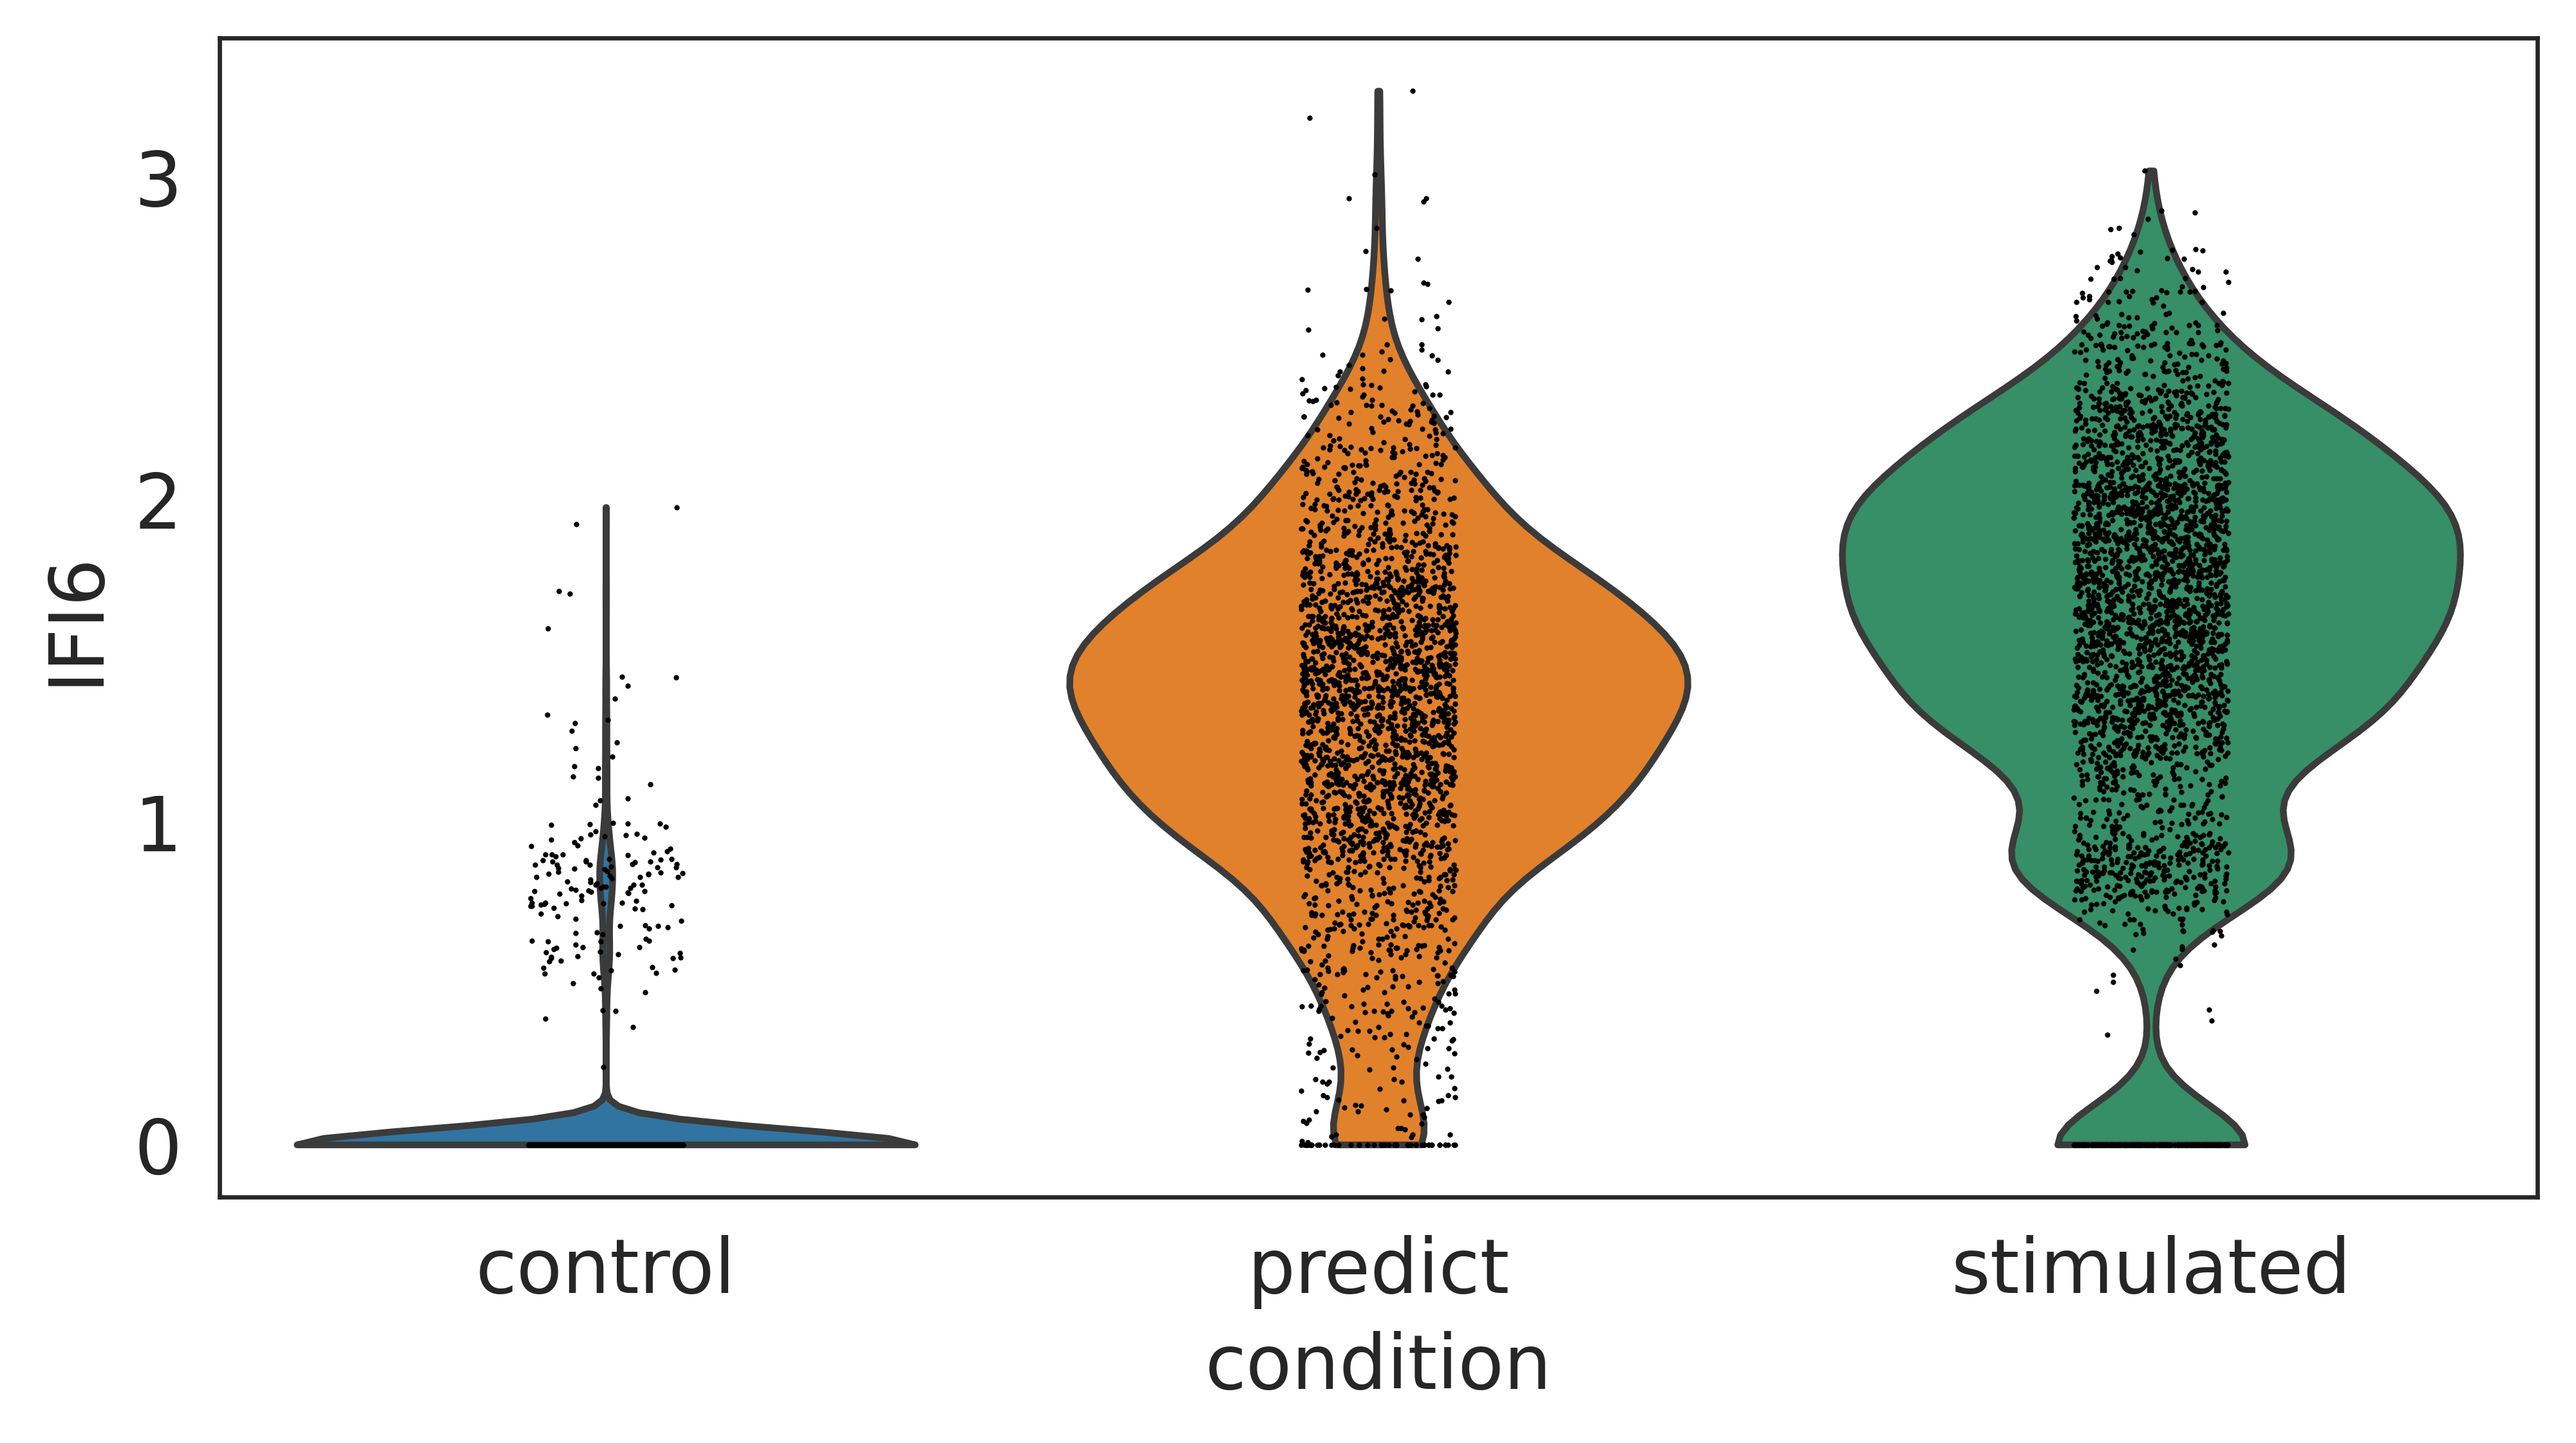

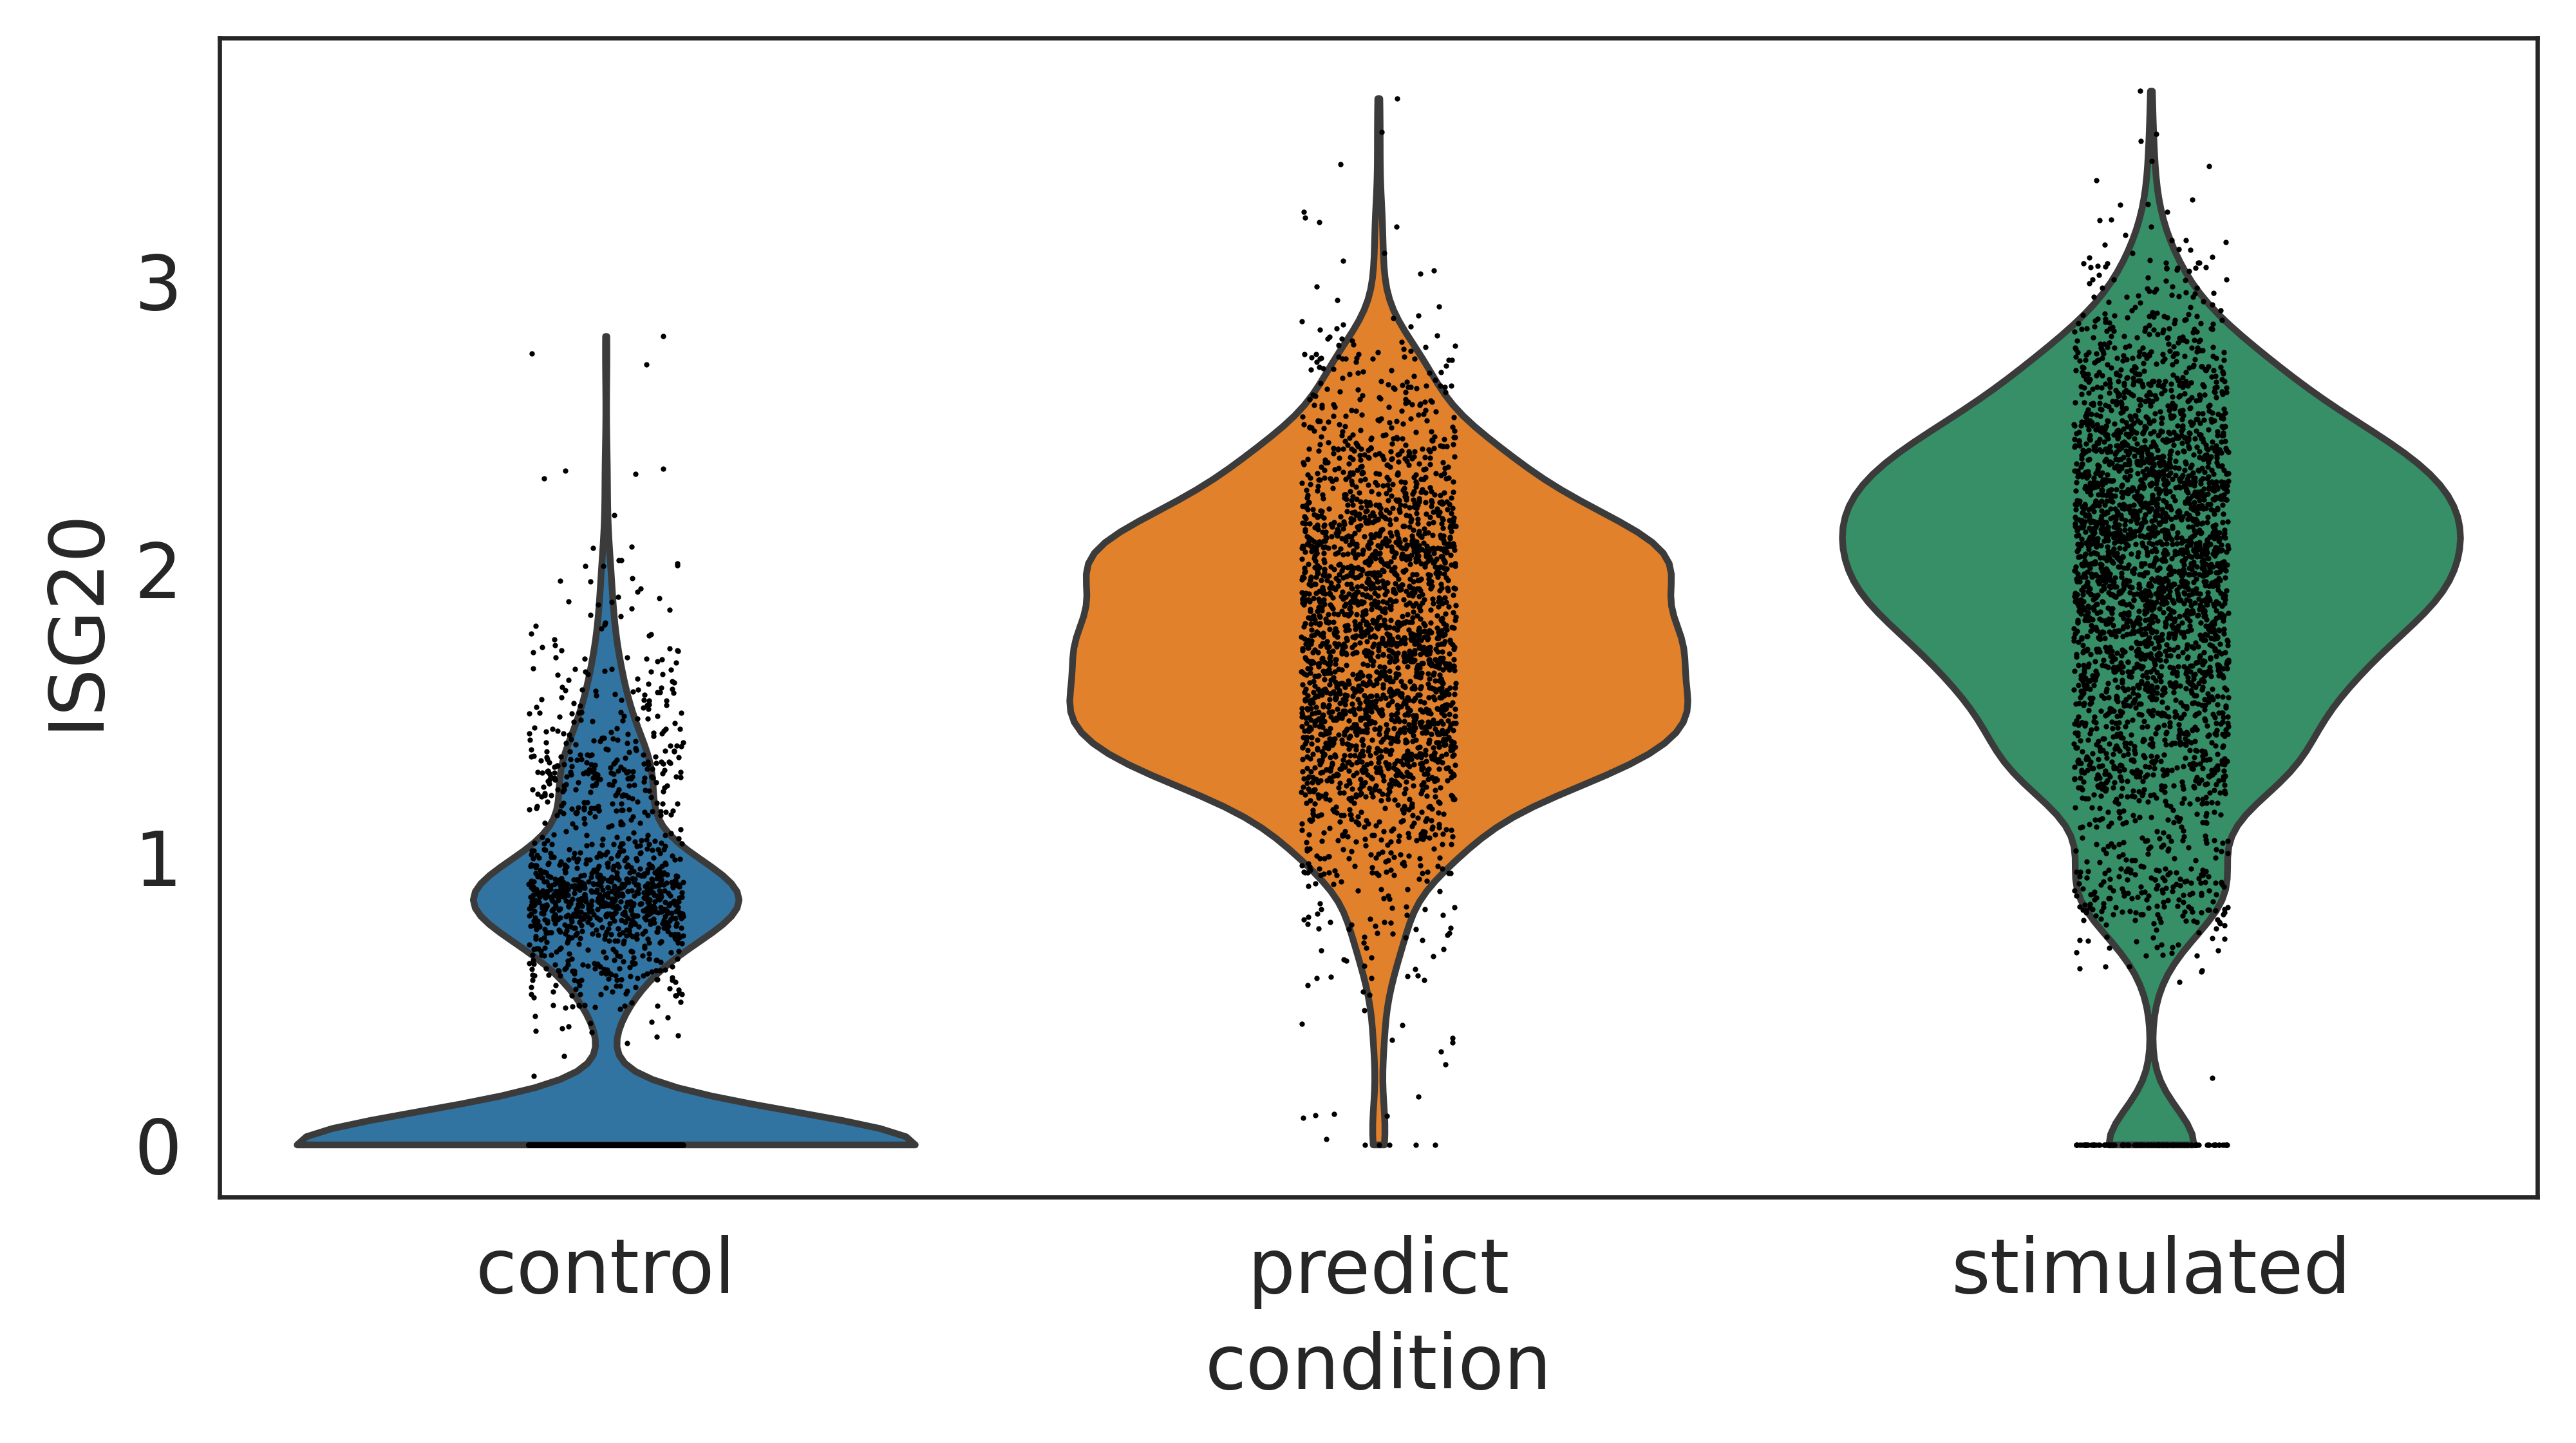

In [ ]:

noise_rate=0.1
num_heads=0
latent_dim=200
hidden_dim=1000
epochs = 400  # 400
lr = 3e-4
distance = 1
mmd_weight = 50
cycle_weight = 0
mmd = True
batch_size = 256

cell_to_pred = "CD4T"
model = models.scOTM(input_dim=adata.n_vars, latent_dim=latent_dim, hidden_dim=hidden_dim, noise_rate=noise_rate, num_heads=num_heads, cycle_weight=cycle_weight, add_weight=mmd_weight, device='cuda:0')
model = model.to(model.device)

train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
            (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
x_, x_hat_ = model.train_scOTM(train, epochs=epochs,lr=lr,weight_decay=1e-5,batch_size=batch_size)
# Predict
adata_to_pred = adata[((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                    (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']))]
pred,ctrl,stim,test_z = model.predict_new(train_adata=train,
                    cell_to_pred=cell_to_pred,
                    key_dic=key_dic,
                    ratio=0.005,
                    r=distance,)
# Evaluate
ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
eval_adata = ground_truth.concatenate(pred)
evaluate.evaluate(data_name=dataname,
                eval_adata=eval_adata, 
                key_dic=key_dic, save_path=None, return_fig=False)